In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage
import pandas as pd

bucket_name = 'loan-data-bucket-anmol'
file_name = 'LendingClub Dataset.csv'
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_name)
blob.download_to_filename('/tmp/loan_data.csv')

df = pd.read_csv('/tmp/loan_data.csv', low_memory=False)
df.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(2260701, 151)

In [ ]:
df['loan_status'] = df['loan_status'].str.strip()

In [ ]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


In [ ]:
df = df[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [ ]:
df.shape

(1345310, 151)

In [ ]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':0, 'Charged Off':1})


<ipython-input-8-1773127825>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].map({'Fully Paid':0, 'Charged Off':1})


In [ ]:
print(df['loan_status'].value_counts())
df.shape

loan_status
0    1076751
1     268559
Name: count, dtype: int64


(1345310, 151)

In [ ]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [ ]:
columns_to_drop = [
    'id', 'member_id', 'funded_amnt', 'funded_amnt_inv',
    'grade', 'sub_grade', 'emp_title', 'url', 'title', 'zip_code',
    'addr_state', 'earliest_cr_line', 'out_prncp', 'out_prncp_inv',
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
    'next_pymnt_d', 'application_type', 'policy_code', 'emp_length',
    'issue_d']

In [ ]:
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [ ]:
df.shape

(1345310, 122)

In [ ]:
missing = df.isnull().sum()
missing = missing[missing >0].sort_values(ascending=False)
missing

,0
orig_projected_additional_accrued_interest,1341551
hardship_amount,1339556
hardship_dpd,1339556
hardship_loan_status,1339556
hardship_type,1339556
...,...
dti,374
collections_12_mths_ex_med,56
chargeoff_within_12_mths,56
tax_liens,39


In [ ]:
# drop columns with more than 95% missing value
# mean give us percentage of missing value and will drop the columns having more than 95%
#index means column name
missing_percent  = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent>0.95].index
df = df.drop(columns=cols_to_drop)

In [ ]:
df.shape

(1345310, 86)

In [ ]:
print(f"Dropped {len(cols_to_drop)} mostly-empty columns.")

Dropped 36 mostly-empty columns.


In [ ]:
# fill few important columns with small number of NaNs
# fill numeric column with median

In [ ]:
df["dti"] = df['dti'].fillna(df['dti'].median())
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].fillna(0)
df['chargeoff_within_12_mths'] = df['chargeoff_within_12_mths'].fillna(0)
df['tax_liens'] = df['tax_liens'].fillna(0)
df['inq_last_6mths'] = df["inq_last_6mths"].fillna(0)

In [ ]:
df.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
home_ownership,0
...,...
total_bc_limit,47281
total_il_high_credit_limit,67527
hardship_flag,0
disbursement_method,0


In [ ]:
# remove high leakeage column that leaked information from the future, cheating for ML

In [ ]:
leaks_cols = [
    'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_credit_pull_d',
    'policy_code', 'settlement_status', 'settlement_date',
    'settlement_amount', 'settlement_percentage', 'settlement_term'
]

df = df.drop(columns = [col for col in leaks_cols if col in df.columns])

# Drop ID columns
id_cols = ['id','member_id']
df = df.drop(columns = [col for col in id_cols if col in df.columns ])

# drop duplicate/similar values
dup_cols = ['funded_amnt','funded_amnt_inv']
df = df.drop(columns=[col for col in dup_cols if col in df.columns])

print("Final shape after cleaning:", df.shape)

Final shape after cleaning: (1345310, 86)


In [ ]:
df.columns.tolist()

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'pymnt_plan',
 'desc',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_

In [ ]:
#EDA Begins


In [ ]:
import matplotlib.pyplot as plt
import seaborn as snb # fancy version built on top of matplotlib

In [ ]:
# 1 EDA:- What is the class balance?
# Are most loans "Fully Paid" or "Charged Off"?

loan_counts = df['loan_status'].value_counts()
loan_counts

,count
loan_status,
0,1076751
1,268559


In [ ]:
# set the visual style of the plot ( grid background)
snb.set(style="whitegrid")

#create a new empty figure(canvas), and set its size

plt.figure(figsize=(6,4))

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<ipython-input-28-983487977>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  snb.barplot(x=loan_counts.index, y=loan_counts.values,palette= 'viridis')


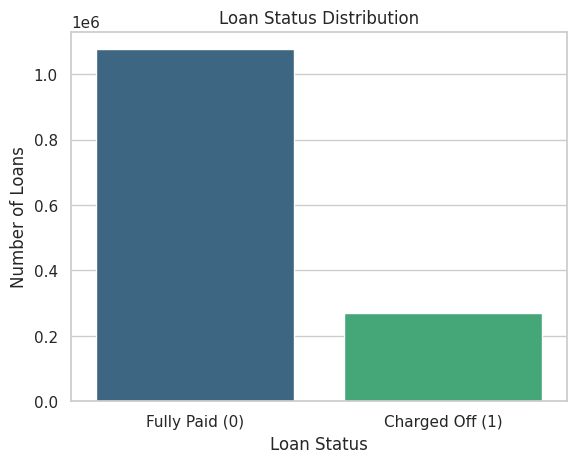

Loan Status Count:
loan_status
0    1076751
1     268559
Name: count, dtype: int64


In [ ]:
# Drawing a bar chart
# x=classes ( 0 and 1),  y= number of loans
#palette="virdis" gives the bar a nice color gradient

snb.barplot(x=loan_counts.index, y=loan_counts.values,palette= 'viridis')

#change the label on the x axis from 0/1 to human readable form
plt.xticks([0,1],['Fully Paid (0)','Charged Off (1)']) # xticks change the label in the x axis

plt.ylabel('Number of Loans') # add label to y axis
plt.xlabel("Loan Status") # add lable to x axis

plt.title("Loan Status Distribution")
plt.show()

print("Loan Status Count:")
print(loan_counts)

<ipython-input-29-1967844686>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  snb.boxplot(x="loan_status", y='loan_amnt', data = df, palette='Set2')


Text(0.5, 1.0, 'Loan Amount vs Loan Status')

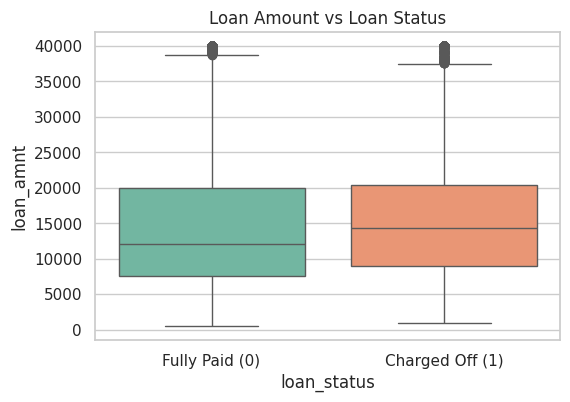

In [ ]:
# 2.) Loan Amount vs Loan Status
# Do people who take bigger loans default more often?
# this helps us understand if loan amount is a risk factor.


snb.set(style="whitegrid")
plt.figure(figsize=(6,4))

snb.boxplot(x="loan_status", y='loan_amnt', data = df, palette='Set2')
plt.xticks([0,1], ['Fully Paid (0)', 'Charged Off (1)'])
plt.title("Loan Amount vs Loan Status")

<ipython-input-30-2229508999>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  snb.boxplot(x='loan_status', y='annual_inc', data = df, palette='Set3')


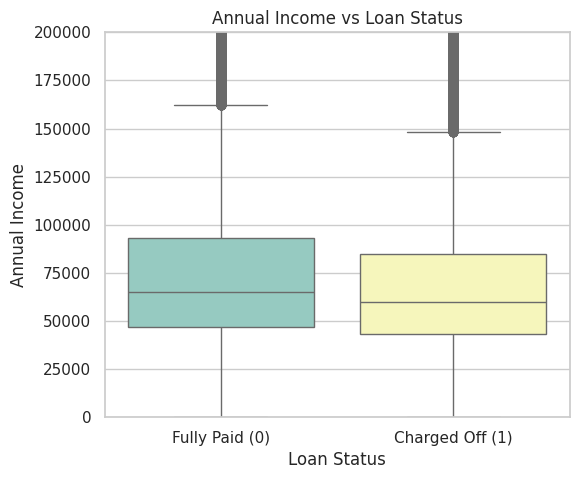

In [ ]:
#3.) Check whether income or DTI (debt-to-income) impacts loan default.
# Because banks want to know:
#Are people with low income more risky?
#Is someone already in too much debt (DTI) a bad idea to lend to?

snb.set(style="whitegrid")

plt.figure(figsize=(6,5))

snb.boxplot(x='loan_status', y='annual_inc', data = df, palette='Set3')

plt.xticks([0,1],['Fully Paid (0)', 'Charged Off (1)'])

plt.title("Annual Income vs Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Annual Income")

# set max y-axis to 2,00,000-hiding extreme income outliers
plt.ylim(0, 200000)
plt.show()

<ipython-input-44-1173226796>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  snb.boxplot(x='loan_status',y='dti', data = df, palette='Set2')


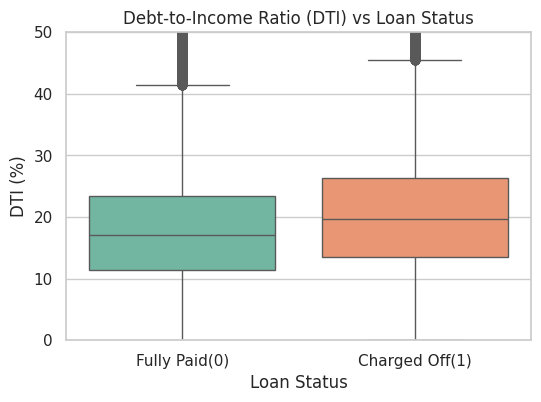

In [ ]:
# 4.) Do borrowers with higher DTI (Debt-to-Income Ratio) default more often?

snb.set(style = 'whitegrid')

plt.figure(figsize=(6,4))

snb.boxplot(x='loan_status',y='dti', data = df, palette='Set2')
plt.xticks([0,1],['Fully Paid(0)', 'Charged Off(1)'])

plt.title("Debt-to-Income Ratio (DTI) vs Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("DTI (%)")

plt.ylim(0,50)
plt.show()

<ipython-input-49-201978740>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  snb.boxplot(x='loan_status', y="fico_score", data=df, palette="Set3")


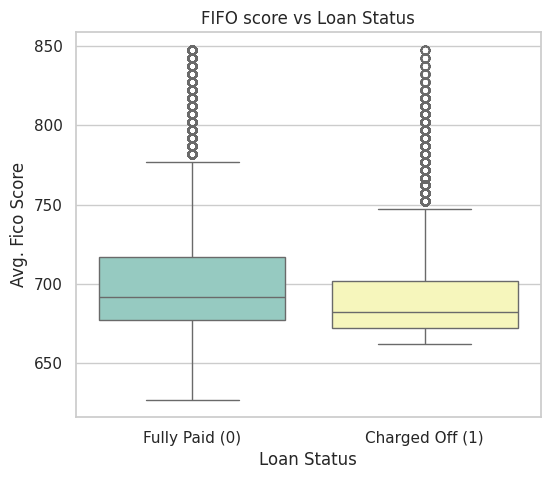

In [ ]:
#5.Do borrowers with lower credit scores (FICO) have a higher chance of defaulting on loans?

snb.set(style = "whitegrid")

# we are gonna create a new column for average FICO
# This column combines both low and high FICO value (approx)

df['fico_score'] = (df['fico_range_low'] + df["fico_range_high"])/ 2

plt.figure(figsize=(6,5))
snb.boxplot(x='loan_status', y="fico_score", data=df, palette="Set3")

plt.xticks([0,1], ['Fully Paid (0)', 'Charged Off (1)'])

plt.title("FIFO score vs Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Avg. Fico Score")

plt.show()

<Figure size 800x500 with 0 Axes>

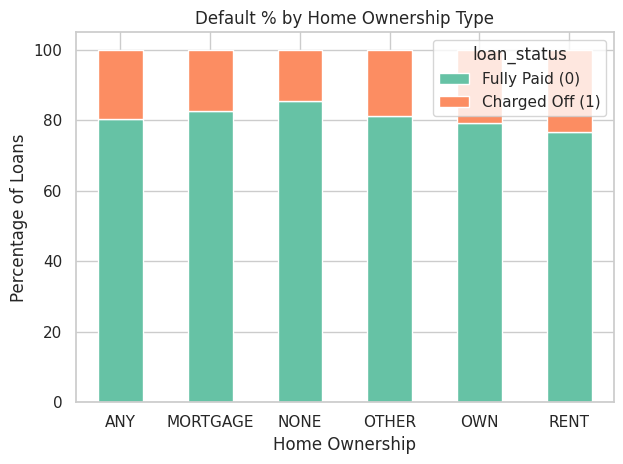

In [ ]:
# 6.) Home Ownership vs Default (in %)
# Which home ownership types have a higher default rate?

# we need to group home_ownership and loan status

group = df.groupby(["home_ownership", "loan_status"]).size().unstack()

# step 2 convert each raw count to percentages
#this is normalize each row so total = 100%
# Now we can compare defaults % in each home_ownership category

percent = group.div(group.sum(axis = 1), axis = 0) *100
plt.figure(figsize=(8,5))

percent.plot(kind="bar", stacked=True,color=['#66c2a5','#fc8d62'])

plt.title("Default % by Home Ownership Type")
plt.xlabel("Home Ownership")
plt.ylabel("Percentage of Loans")
# add legend to explain which color is what
plt.legend(["Fully Paid (0)","Charged Off (1)"], title='loan_status')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

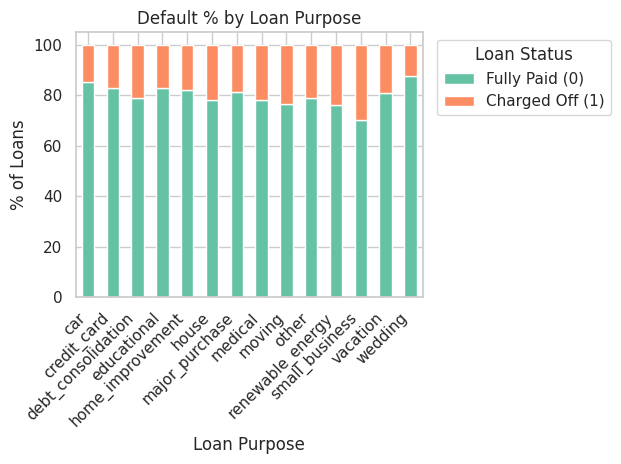

In [ ]:
#6.2) Are some loan purposes (like small business, medical, vacation) riskier than others?
# we need to group purpose and loan status

group = df.groupby(['purpose','loan_status']).size().unstack()

percent = group.div(group.sum(axis=1),axis=0)*100

plt.figure(figsize=[12,6])

percent.plot(kind="bar",stacked=True, color=['#66c2a5','#fc8d62'])

plt.title("Default % by Loan Purpose")
plt.xlabel("Loan Purpose")
plt.ylabel('% of Loans')
plt.xticks(rotation=45, ha='right')

plt.legend(["Fully Paid (0)", 'Charged Off (1)'],
           title="Loan Status",
           bbox_to_anchor=(1.02,1),loc="upper left")

plt.tight_layout()

plt.show()

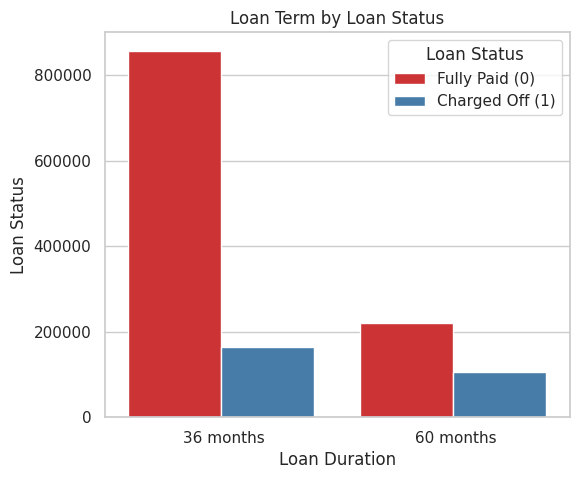

In [ ]:
#6.3) Do longer loan terms lead to more defaults?
# term (36 vs 60 months) vs loan_status

snb.set(style="whitegrid")

plt.figure(figsize=[6,5])

snb.countplot(x="term", hue="loan_status", data=df, palette='Set1')
# we dont need xticks for a countplot cause "term" already has 36months and 60months

plt.title("Loan Term by Loan Status")

plt.xlabel("Loan Duration")
plt.ylabel("Loan Status")

plt.legend(title ="Loan Status",labels=["Fully Paid (0)","Charged Off (1)"])

plt.show()

In [ ]:
# Save the cleaned DataFrame to a CSV file in the Colab environment
df.to_csv("/content/cleaned_loan_data.csv", index=False)


In [ ]:
from google.colab import files
files.download("/content/cleaned_loan_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>